# SEIQR model - group 1G

Hanbing Zhang, Maria Yuffa, Tamas Noszko, Yuchen Jiang

## Overview

This project models the spread of viruses under the influence of intervention. We are using a cellular automata, a grid of cells with assigned states, which updates over time based on the states of neighbouring cells and according to specific rules.

## Introduction
<a id='introduction'></a>

SARS-COV-2 is a disease that turned into pandemic in 2019. It mainly affects human respiratory system and is primarily transmitted through respiratory particles.
Governments have taken various interventions to control the epidemic such as virus specific testing and introducing quarantining rules.

Cellular automata is a very convenient and effective model to understand the spread of the virus and the impact of these interventions.

S. Ghosh and S. Bhattacharya have studied and accurately modelled the infection spread in time and space *[[1.]](#references)*. The purpose of our project is to simulate and reproduce the results provided by the their article and present some insights that may have led to better predictions and restrictive measures.


The SEIQR model assumes that when an infectious disease strikes a community, the population can be divided into 5 different categories:

*  those who are susceptible (denoted by S)
*  those who are exposed and asymptomatically infected (denoted by E)
*  those who are already infected, but not yet quarantined (denoted by I)
*  those who have been quarantined (denoted by Q) 
*  and those who are already recovered (denoted by R)

We determine the transition between these states of cells by applying 7 simple rules to each individual cell at the same time:

* If any one of 8 neighbours are exposed or infected, then the person has a 50% probability to get exposed or infected.
* Exposed people have a 7 days incubation period and have a 70% probability to show the symptoms of the disease and become infected.
* Infected people are not tested for the first 2 days of infection and have a 60% probability to be tested thus quarantined.  Here we assume the virus will last for 14 days and if they are not detected, after 14 days they will recover.
* A quarantined person is restricted for 10 days, after that they will recover.
* People who have recovered will remain in recovery and will not be reinfected.
* The total population is constant.
* We do not consider death due to the disease separately in our model.

Then we use codes about these rules to update the cell states every frame simultaneously.

A visual representation of the possible interaction between states can be seen below, on *Figure 1.*

<p align="center">
  <img   src="possible_states.png">
  <br>
  <em>Figure 1. - Possible interactions  </em>
</p>



## Methodology

### Packages

To make our model work we used the following 6 packages:

| Package                      | Description                                                                                  |
| -----------------------------| ---------------------------------------------------------------------------------------------|
| `matplotlib,pyplot`          | For plotting the population grid or visualising the matrix                                   |
| `numpy as np`                | Manipulating matrices                                                                        |
| `ffmepg`                     | Animating the population progression                                                         |
| `IPython.display import HTML`| Used for animating the change in matrix and displaying it in form of HTML video              |
| `matplotlib.animation`       | To animate the matrix progression                                                            |
| `random as rand`             |To randomly assign the infected people in initial state function and randomly change the rules|


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import ffmpeg
from IPython.display import HTML
import matplotlib.animation as ani
import random as rand
import matplotlib

### Initial Function

There are several ways in which infection can invade population. In here we consider 3 such types:
1. 'single' - when only one person is infected; 
2. 'random' - when several people are carriers of the virus;
3. 'cluster' - when a group of people close to each other are infected. 'cluster' condition is defined to be a person and its neighbourhood suffering from the virus.

It is necessary to specify what proportion of the population can be affected as in the case of COVID-19 number of people who haven't experienced symptoms have carried on with their lives as normal. Also, some people are not affected by the disease no matter how many times they get in touch with the infected neighbours. Here, 0 stands for people who are not affected by the virus no matter what and 1 reflects people who are susceptible to the disease. All of this is represented by numpy array.


In our case we assumed that 70% of the population can be affected. We have therefore randomly selected 70% of the cells to be susceptible.

To separate between states we have used if, elif and else statements. The process to create the single and random cases are relatively similar, with the only difference being that for the random one instead of selecting one random x and y coordinate, we have n random coordinate pairs.

The hardest case to consider is the cluster as we have to ensure that we do not encounter the border of the grid when we assign infected state. For example, to check south neighbour and north-east neighbour we do:

```    
      arr[x][y-1] = 2 if y-1>0 else arr[x][y-1]

      arr[x+1][y+1] = 2 if x+1<grid_size and y+1<grid_size else arr[x+1][y+1]
```
Where arr is the initial state matrix that we are creating.

Once the initial state is created, we create an array with the same shape, consisting of null values. This will be used later to keep track of time for each individual cell.
With the initial state and time array complete we can feed them into our main "tick" function.

(To account for typos, if other words are used other than 'single', 'random', 'cluster' the initial state function will give the outcome: "The input is invalid! Please try again.")

### The "tick" function
Our main function is the so called "tick" function. This function is responsible for creating the next state of the whole system, a new "tick" in its evolution.

This function consists of three parts (*Figure 2.*):

1. It reads in the current state of the model,
2. applies rules accordingly to it
3. returns the new state of the system.

The `tick` function has two inputs:
*  `matrix` which corresponds to the initial state of the population, this is produced in the separate `initial_state` function. 
* `tmatrix` which has the same dimensions as `matrix` but contains only null values initially. This is also created in the `initial_state` function.

To be able to keep track of incubation and quarantine time, we use `tmatrix`. This way we can assign an independent timer to each cell in the population.

<p align="center">
  <img src="tick_function.png">
  <br>
  <em>Figure 2 - The tick function.  </em>
</p>

#### 1. Extracting information of neighbours
The aim of this part of the code is to extract the information about the neighbours of each cell. 
Under neighbours we mean the arrangement of cells described by the "Moore neighbourhood" (*Figure 3.*).

<p align="center">
  <img width="400"  src="more_nbs.png">
  <br>
  <em>Figure 3 - Moore neighbourhood</em>
</p>

We achieve this using two for loops cycling true each cell of our $i \times j$ size matrix. Then we add or subtract from the $i^{th}$ or $j^{th}$ position to reach its neighbours and store their state values according to their positions. We also consider that on the edges of the matrix no neighbours are possible, we note this by giving it a value of -1. 

#### 2. - 3. Applying rules and changing states

To apply the matching rule from the ones outlined in the *[introduction](#introduction)* section we consider two things:

1. The state values of the cell's neighbours,
2. and the cell's own timer value, for the cases with time dependence.

For each state we have a corresponding rule, which we can apply. Most rules have a probability element in them, to achieve this we are using the `random.randint` function from the numpy library. We create a random number between 0 and 100 and set a limit which it has to surpass or stay below. E.g. to get a 70% probability, the generated number has to be greater than 30 (or less than 70). If it passes the criteria the state of the cell changes accordingly.


For states such as the "quarantine" state the cell's "timer" value is also needed. In these cases the rule checks whether a certain time has passed, or if a cell just moved to quarantine: whether the timer has started.

For the "exposed" and the "infected" states the probability aspect and the time dependence are combined. After a certain time has passed there is a given probability which decides the new state.


Once the rules have been applied we store the new state of the cell in the `new_state` variable.

## Animating and plotting the result:

To visualize our results we produce an animation representing the spread of the virus. We achieve this by plotting the matrix after every iteration and store these images in a list. Then we use the `ArtistAnimation` function from the `matplotlib.animation` library. We feed in the list of images and specify that for how long should each image show. Finally to make the animation easier to follow we specify a colourmap that matches each state value to a distinct colour.


In [11]:
# Animation example. (In case its present, please click "Fetch additional output..." after running this cell.)

from MyMainPackage import main_executable_script_1

matrix, tmatrix = main_executable_script_1.initial_state('cluster',2500)
main_executable_script_1.animator_on(100, 100, matrix, tmatrix, 10) 

As an addition we plot the progression of the states over time, this makes it easier to analyse and compare the different initial states and their consequences.


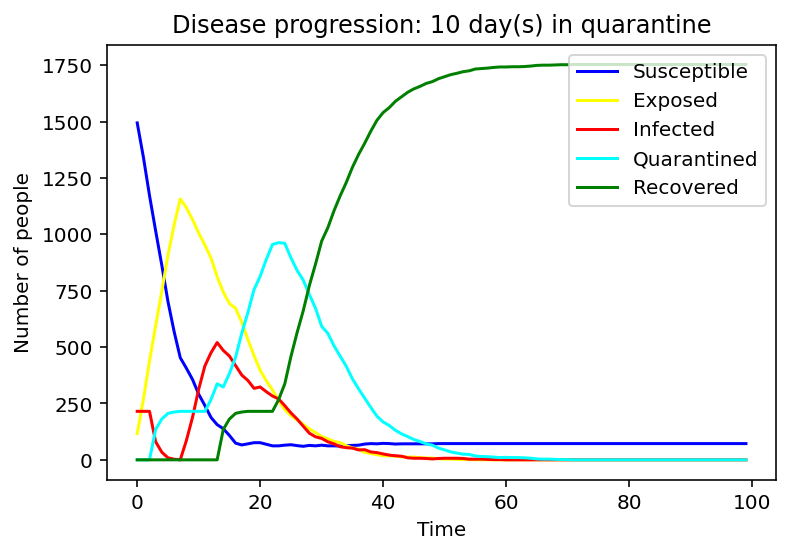

In [12]:
# Plotting example.

from MyMainPackage import main_executable_script_1

matrix, tmatrix = main_executable_script_1.initial_state('cluster',2500)
main_executable_script_1.animator_q(100, 100, matrix, tmatrix, 10) 

## Results

### Comparisons between 3 different initial states


We assumed three different initial conditions with different types of infection: the single one, random, and cluster. The following three graphs show changes in the numbers of each population over time under these different conditions.


For a single infected case, only the susceptible and recovered population appears to be changing monotonically, while the other three populations appear to look like bell curves. The amount of alterations is especially noticeable in S and R. 


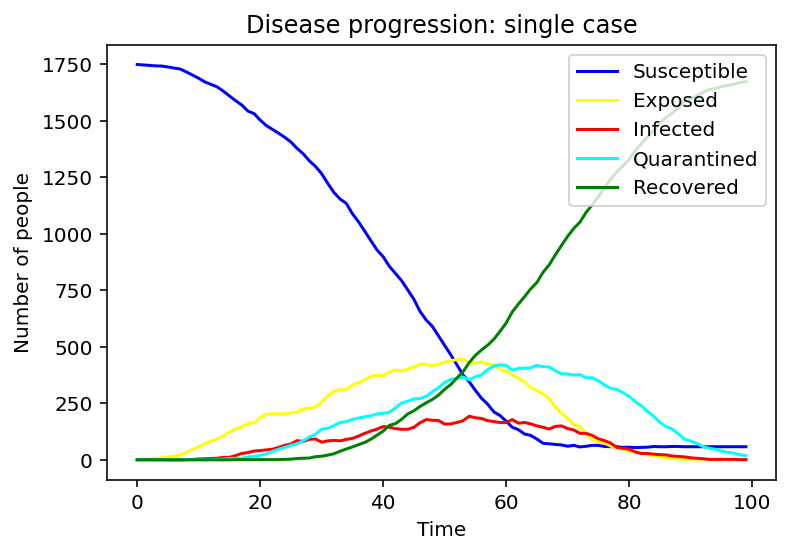

In [13]:
#Plot showing the single case with 10 days in quarantine.

from MyMainPackage import main_cases

matrix, tmatrix, type_inf = main_cases.initial_state('single', 2500)
main_cases.animator_q(100, 100, matrix, tmatrix, type_inf, 10)


To make better comparisons, we set the infected people in random and cluster constant and to see the only effect of the different infection models. 

For the random case, the susceptible population decreases slower. The exposed, infected, and quarantined population curves flatten out, reaching peaks later with smaller values. 



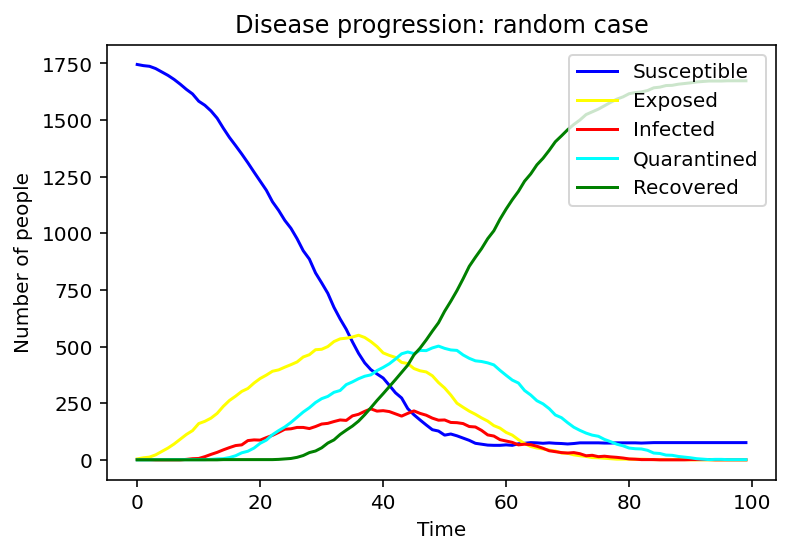

In [5]:
#Plot showing the random case with 10 days in qarantine.

from MyMainPackage import main_cases

matrix, tmatrix, type_inf = main_cases.initial_state_fix('random', 2500)
main_cases.animator_q(100, 100, matrix, tmatrix, type_inf, 10)


In cluster one, the susceptible population declines at a greater rate than the rate in the random case, and the recovered population grows at a greater rate as well. We can also notice that the peak periods of exposed, infected, and quarantined populations from the cluster case appear earlier than the times from the random case. 

From these three progress diagrams of different initial states, we can see that if the same prevention and control measures are used, the following situation can be very different. Therefore, it is necessary to adjust the restrictions according to the current situation.



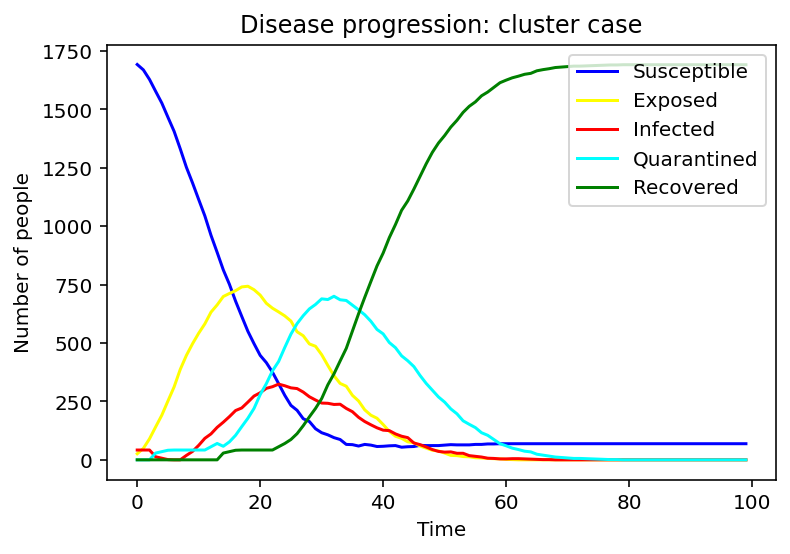

In [6]:
#Plot showing the cluster case with 10 days in quarantine.

from MyMainPackage import main_cases

matrix, tmatrix, type_inf = main_cases.initial_state_fix('cluster', 2500)
main_cases.animator_q(100, 100, matrix, tmatrix, type_inf, 10)

### Optimal quarantine time

After plotting the graphs for susceptible, exposed, infected, quarantined and recovered people we decided to pursue the question: 'What would be the optimal quarantine time to minimise the spread of the infection?'


We have first considered the case of a spread due to a single person being infected. We compared the spread for 1 day, 9 days and 15 days of quarantine.


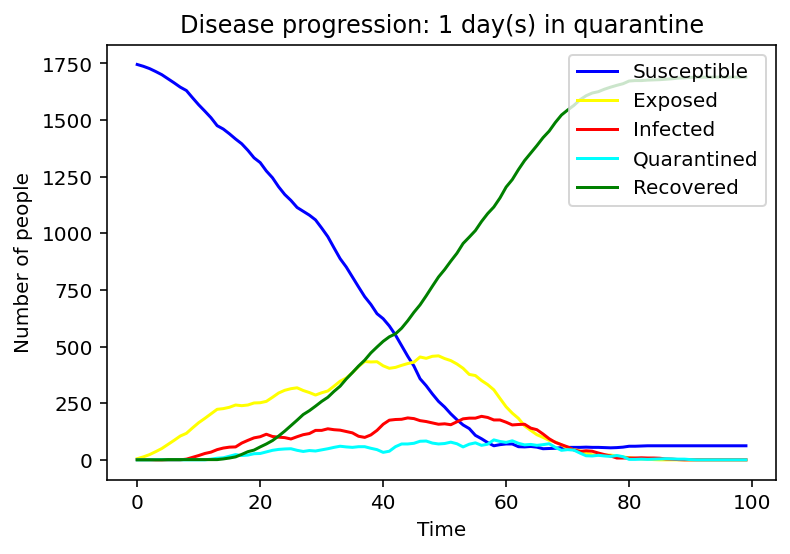

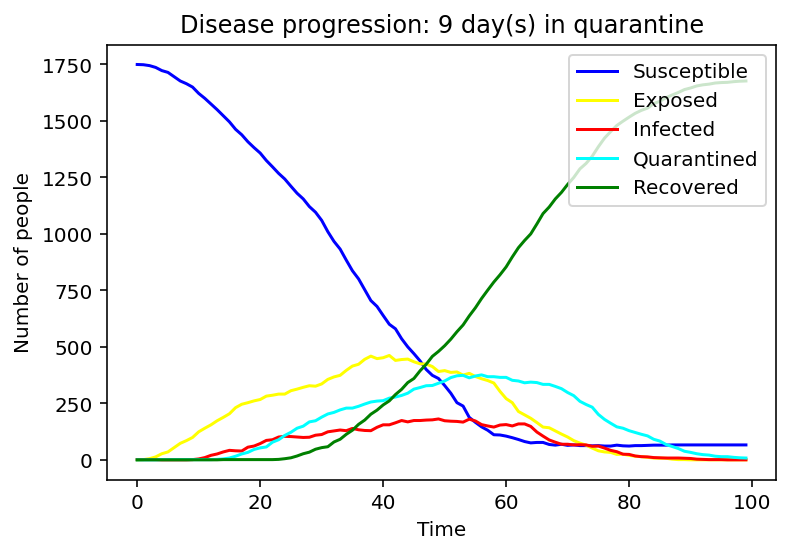

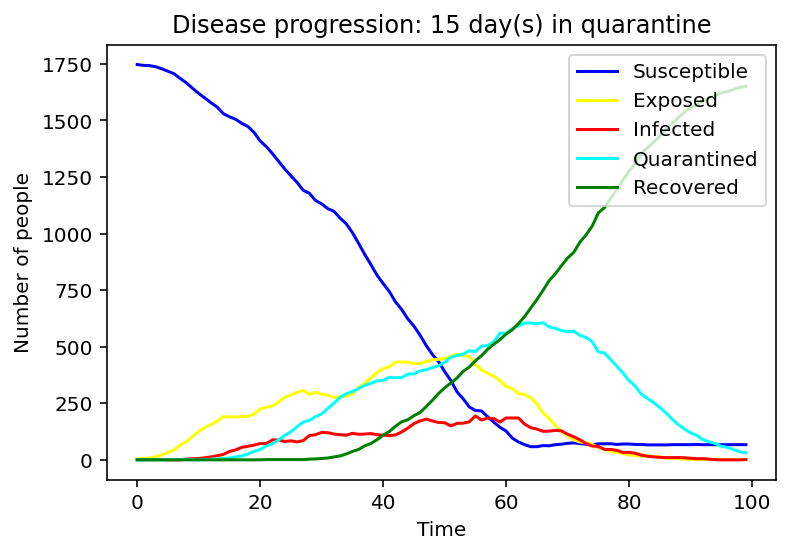

In [7]:
#Plots showing the effect of different lengths of quarantine time.
%run ./quarantine_comp_script.ipynb


Evidently, as the quarantine time grows, number of people quarantining increases, hence, formation of a peak of the cyan graph is observed for the 9-day quarantine with a clearer one seen at 15 days. On the contrary the line graph which reflects the number of people exposed to the COVID-19 infection is flattening as quarantine time increases. Same applies to the infected population - the disease spreads faster as people who have left the quarantine early will carry on transmitting the disease.
As we can observe, disease spreads faster at small quarantine time. This could be implied from the intersection between the susceptible and recovered graphs: as time progresses less people can catch the disease whereas those who have been affected will make a recovery.

Seemingly easy query, we stumbled upon the factors that bring the quarantine time down, such as state of mental health, medication or dietary requirements, probability of a person leaving the isolation prematurely, etc.
Hence, without these factors the optimal quarantine time would increase exponentially leading to the delay of the spread.

As the above is not a feasible solution, it makes sense to match the quarantine time with the length of the average course of the virus.

A focus on testing has a more definite result. It an increase the number of people quarantineing, hence lowering the number of indiviuals who can possibly spread the virus.

## Extensions

Taking the idea further we have considered the case of 2 cities and have established a border between them. We have assumed there was no health control present between them. 

- Animation of this instance has showed that even leaving a small 'hole' through which infection can infiltrate into the healthy population, results in complete spread of the disease to another city.

- In order to make cities symmetrical, we have considered the case for odd and even values of grid_size. Moreover, to accurately construct the map, we have split the initial_state matrix into 3 arrays and used `np.concatenate()` function to augment them.

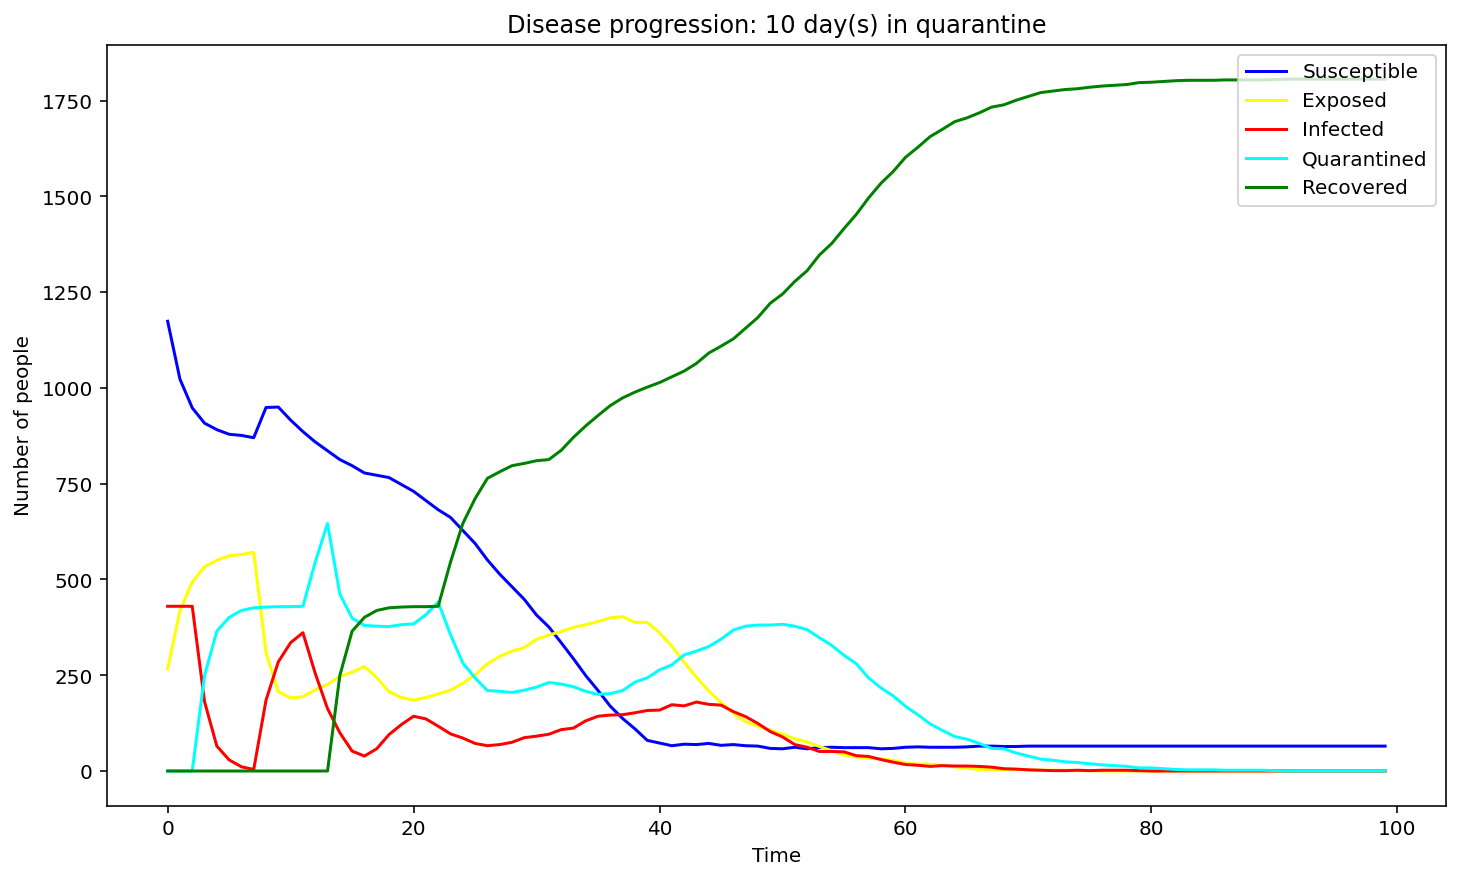

In [8]:
#Lockdown case animation and plot. (In case its present, please click "Fetch additional output..." after running this cell.)
from MyMainPackage import main_executable_script_1

matrix, tmatrix = main_executable_script_1.isolation(2500)
main_executable_script_1.animator(100, 100, matrix, tmatrix, 10) 

## References
<a id='references'></a>

*[1.]* -  Ghosh, S., & Bhattacharya, S. (2021). Computational model on COVID-19 pandemic using probabilistic cellular automata. SN Computer Science, 2(3), 1-10.


*[Figure 3]* -  MorningLemon (2015) [Die Moore-Nachbarschaft besteht aus 8 Zellen, welche die mittlere Zelle C umschließen.].[png file]. https://en.wikipedia.org/wiki/Moore_neighborhood#/media/File:Moore_neighborhood_with_cardinal_directions.svg
